In [133]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import rcParams
import time
import diffusionstuff6 as ds
from copy import copy as dup
from scipy.integrate import odeint

# Graphics parameters
%matplotlib notebook
ticklabelsize = 15
fontsize = 20
linewidth = 2
fignum = 0

loading NeshData/continuum_model6 20-5-2016[2][5].npz


<IPython.core.display.Javascript object>


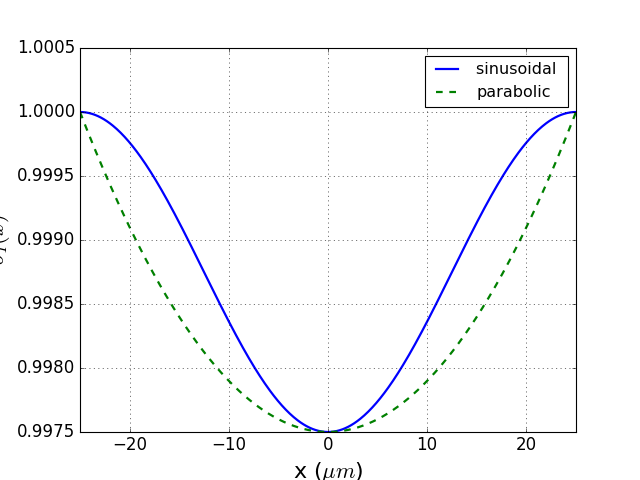

In [134]:
# All the parameters

# lastfile = 'NeshData/continuum_model6 20-5-2016[2][1].npz'; Load_old_file = True
# nextfile = 'NeshData/continuum_model6 20-5-2016[2][2].npz'; Save_new_file = True
# trajfile = 'NeshData/continuum_model6 20-5-2016[2][2].traj.npz'; trajflag = True
# traj0file= 'NeshData/continuum_model6 20-5-2016[2][2].traj0.npz'; traj0flag = True

# lastfile = 'NeshData/continuum_model6 18-5-2016[1][6].npz'; Load_old_file = True
# nextfile = 'NeshData/continuum_model6 18-5-2016[1][7].npz'; Save_new_file = True
# trajfile = 'NeshData/continuum_model6 18-5-2016[1][7].traj.npz'; trajflag = True
# traj0file= 'NeshData/continuum_model6 18-5-2016[1][7].traj0.npz'; traj0flag = True

# lastfile = 'NeshData/continuum_model6 20-5-2016[3][5].npz'; Load_old_file = True
# nextfile = 'NeshData/continuum_model6 20-5-2016[3][6].npz'; Save_new_file = True
# trajfile = 'NeshData/continuum_model6 20-5-2016[3][6].traj.npz'; trajflag = True
# traj0file= 'NeshData/continuum_model6 20-5-2016[3][6].traj0.npz'; traj0flag = True

# lastfile = 'NeshData/continuum_model6 20-5-2016[3][7].npz'; Load_old_file = True
# nextfile = 'NeshData/continuum_model6 20-5-2016[3][8].npz'; Save_new_file = True
# trajfile = 'NeshData/continuum_model6 20-5-2016[3][8].traj.npz'; trajflag = True
# traj0file= 'NeshData/continuum_model6 20-5-2016[3][8].traj0.npz'; traj0flag = True

# lastfile = 'NeshData/continuum_model6 20-5-2016[4][3].npz'; Load_old_file = True
# nextfile = 'NeshData/continuum_model6 20-5-2016[4][4].npz'; Save_new_file = True
# trajfile = 'NeshData/continuum_model6 20-5-2016[4][4].traj.npz'; trajflag = True
# traj0file= 'NeshData/continuum_model6 20-5-2016[4][4].traj0.npz'; traj0flag = True

# lastfile = 'NeshData/continuum_model6 18-5-2016[1][7].npz'; Load_old_file = True
# nextfile = 'NeshData/continuum_model6 18-5-2016[1][8].npz'; Save_new_file = True
# trajfile = 'NeshData/continuum_model6 18-5-2016[1][8].traj.npz'; trajflag = True
# traj0file= 'NeshData/continuum_model6 18-5-2016[1][8].traj0.npz'; traj0flag = True

# lastfile = 'NeshData/continuum_model6 20-5-2016[2][2].npz'; Load_old_file = True
# nextfile = 'NeshData/continuum_model6 20-5-2016[2][3].npz'; Save_new_file = True
# trajfile = 'NeshData/continuum_model6 20-5-2016[2][3].traj.npz'; trajflag = True
# traj0file= 'NeshData/continuum_model6 20-5-2016[2][3].traj0.npz'; traj0flag = True

lastfile = 'NeshData/continuum_model6 20-5-2016[2][5].npz'; Load_old_file = True
nextfile = 'NeshData/continuum_model6 20-5-2016[2][6].npz'; Save_new_file = True
trajfile = 'NeshData/continuum_model6 20-5-2016[2][6].traj.npz'; trajflag = True
traj0file= 'NeshData/continuum_model6 20-5-2016[2][6].traj0.npz'; traj0flag = True


# Number of iterations to calculate Nliq from Ntot
niter = 1

# Loading/initializing state
if not Load_old_file:

    # Message
    print "Starting a new system"
    nx = 500 # Number of points in simulation box
    xmax = 50
    #xmax = 20
    x = np.linspace(0, xmax, nx)
    boxpoints = len(x)
    deltaX = x[1]-x[0]
    Nbar = 1.0 # new Nbar from VMD, 260K
    Nstar = .9/(2*np.pi)
    #Nstar = .55/(2*np.pi)

    # Initialize as a pre-equilibrated layer of liquid over ice
    Nice = np.zeros(boxpoints)+1
    Fliq = ds.getNliq(Nice,Nstar,Nbar,niter)

else:
    
    # Message
    print "loading", lastfile
    npzfile = np.load(lastfile)
    Fliq = npzfile['Fliq']
    Nice = npzfile['Nice']
    Nbar = npzfile['Nbar']
    Nstar = npzfile['Nstar']
    x = npzfile['x']
    boxpoints = len(x)
    nx = len(x)
    deltaX = x[1]-x[0]
    
# Lay out the system
Ntot = Fliq + Nice
nmid = int(nx/2)
nquart = int(nx/4)
xmid = max(x)/2
xmax = x[nx-1]
Nice_start = Nice[0]
Niceoffset = ds.getNiceoffset(Nbar, Nstar, 1, 0) # Should be close to .75; not used if D=const

# Just conversions
nmpermonolayer = 0.3
umpersec_over_mlyperus = (nmpermonolayer/1e3*1e6)

# Diffusion coefficient
D = 0.02e-2 # micrometers^2/microsecond

# Time steps
dtmaxtimefactor = 10
dtmaxtimefactor = 100
dtmax = deltaX**2/D
deltaT = dtmax/dtmaxtimefactor

# Deposition rate
nu_kin = 49 # microns/second
deprate = nu_kin/umpersec_over_mlyperus # monolayers per microsecond
deprate_times_deltaT = deprate * deltaT

# Supersaturation
sigma0 = 0.19
sigmastepmax = 0.20 # Must be bigger than sigma0 to get growth
sigmastepmax = 0.30 # Must be bigger than sigma0 to get growth
center_reduction = 0.25 # In percent
c_r = center_reduction/100

# Diffusion coefficient scaled for this time-step and space-step
DoverdeltaX2 = D/deltaX**2

# Gets the function sigma(x)
sigmastep_sinusoid = ds.getsigmastep(x,xmax,center_reduction,sigmastepmax,method='sinusoid')
sigmastep_parabolic = ds.getsigmastep(x,xmax,center_reduction,sigmastepmax,method='parabolic')
sigmastepstyle = 'sinusoid'
if sigmastepstyle=='sinusoid':
    sigmastep = sigmastep_sinusoid
elif sigmastepstyle=='parabolic':
    sigmastep = sigmastep_parabolic
else:
    print 'bad choice'

# Graph sigma(x)
fignum +=1
plt.figure(fignum)
plt.plot(x-xmid,sigmastep_sinusoid/sigmastepmax, \
         x-xmid, sigmastep_parabolic/sigmastepmax, '--',lw=linewidth)
plt.xlim([-xmid,xmid])
plt.legend(['sinusoidal ', 'parabolic'])
plt.xlabel(r'x ($\mu m$)',fontsize=fontsize)
plt.ylabel(r'$\sigma_I(x) $',fontsize=fontsize)
plt.grid('on')

In [135]:
# These are run control parameters

# Flag for explicit updating Fliq(Ntot) every step
updatingFliq = True

# Set up a maximum number of iterations or layers
uselayers = True

# 0D run
if uselayers:
    layermax_0D = 3
else:
    countermax_0D = 100

# 1D run 
if uselayers:
    layermax_1D = 20
else:
    countermax_1D = 30000
    

In [136]:
# Reporting
print "D =", D, 'um^2/us',D * 1e-12*1e6*1e9, 'x 10^-9 m^2/sec'
print 'deltaT_max (Diffusion time)', dtmax
print 'deltaT =', deltaT
print 'deprate =', deprate, 'monolayers/us'
print 'nmid', nmid
print 'N*', Nstar
print 'N*x2pi', Nstar*2*np.pi
print 'Nbar, Nbar-N*, N*/Nbar', Nbar, Nbar-Nstar, Nstar/Nbar
print 'deltaX', deltaX
print 'sigma_0 =', sigma0
print 'sigmastepmax =', sigmastepmax
print 'center reduction', center_reduction, '%'
print 'max growth rate =', deprate*sigmastepmax*umpersec_over_mlyperus, 'um/sec'
print 'min growth rate =', deprate*(sigmastepmax-sigma0)*umpersec_over_mlyperus, 'um/sec'
print 'nu_kin =', nu_kin, 'um/sec'

D = 0.0002 um^2/us 0.2 x 10^-9 m^2/sec
deltaT_max (Diffusion time) 50.200601604
deltaT = 0.50200601604
deprate = 0.163333333333 monolayers/us
nmid 250
N* 0.143239448783
N*x2pi 0.9
Nbar, Nbar-N*, N*/Nbar 1.0 0.856760551217 0.143239448783
deltaX 0.100200400802
sigma_0 = 0.19
sigmastepmax = 0.3
center reduction 0.25 %
max growth rate = 14.7 um/sec
min growth rate = 5.39 um/sec
nu_kin = 49 um/sec


<IPython.core.display.Javascript object>


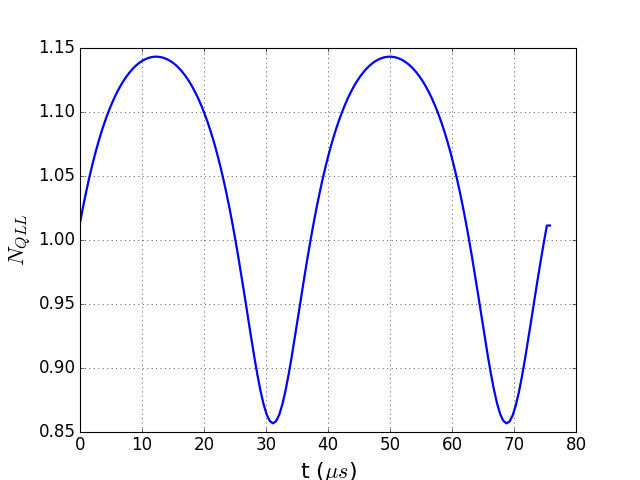

0-D Modeled growth rate, um/s 7.96498950396
0-D Modeled alpha 0.541836020677


In [137]:
# This is the 0-d run

# Bundle parameters for ODE solver
params = [Nbar, Nstar, niter, sigmastepmax, sigma0, deprate]

# Initial conditions for ODE solver
y0 = [Nbar, 0.0]
ylast = dup(y0)

# Time steps
t0 = 0.0
ttot = 0.0
tinterval = [t0, deltaT]

# Initialize the keeper arrays
tkeep_0D = [t0]
ykeep_0D = [y0]
tlast = dup(t0)
Nicelast0 = 0.0
Ntotlast0 = 0.0
Nicelast_start = 0.0
Ntotlast_start = 0.0

# Call the ODE solver
counter = 0
layer = 0
while True:
    
    # Integrate up to next time step
    y = odeint(ds.f0d, ylast, tinterval, args=(params,))
    ylast = list(y[1,:])
    tlast += deltaT
    
    # Stuff into keeper arrays
    ykeep_0D.append(ylast)
    tkeep_0D.append(tlast)
    
    # Make some local copies, with possible updates to Fliq
    Fliqlast, Ntotlast = ylast
    if updatingFliq:
        Fliqlast = ds.getNliq(Ntotlast,Nstar,Nbar,niter) # This updates Fliqlast and ylast!
        ykeep_0D[counter][0] = Fliqlast # Saves the updated Fliq for this step
    Nicelast = Ntotlast - Fliqlast
    Nicelast0 = dup(Nicelast)
    Ntotlast0 = dup(Ntotlast)
    
    # Update counters and see whether to break
    counter += 1
    layer = dup(Ntotlast0) 
    if uselayers:
        if layer > layermax_0D-1:
            break
    else:
        if counter > countermax_0D-1:
            break
    
# Convert results to a numpy array
ykeep_0Darr = np.array(ykeep_0D, np.float64)
tkeep_0Darr = np.array(tkeep_0D, np.float64)

# Plot results
fignum +=1
plt.figure(fignum)
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.plot(tkeep_0D,ykeep_0Darr[:,0],lw=linewidth)
plt.xlabel(r't ($\mu s$)',fontsize=fontsize)
plt.ylabel(r'$N_{QLL} $',fontsize=fontsize)
plt.grid('on')

# Growth statistics
delta_Ntot_0d = Ntotlast0-Ntotlast_start
growthrate_0d_mlyperus = delta_Ntot_0d/tlast # monolayer/us
growthrate_0d = growthrate_0d_mlyperus*umpersec_over_mlyperus # um/sec
print  "0-D Modeled growth rate, um/s", growthrate_0d
alpha_0d = growthrate_0d/nu_kin/sigmastepmax
print  "0-D Modeled alpha", alpha_0d

In [138]:
L = xmax/2; print L # micrometers
c_r = center_reduction / 100; print c_r # dimensionless
nu_kin_ml = deprate; print nu_kin_ml # monolayers per microsecond
sigma_I = sigmastepmax; print sigma_I # dimensionless
print D # D is in micrometers^2/microsecond
M = np.array([.0027, .0025])
B = np.array([2.9, 1.59])
beta = np.array([0.65, 0.65])
xfactor = nu_kin_ml*L**2*c_r**beta*sigma_I/D
NSS = M*xfactor + B
print 'Nss predicted'
print 'sinusoid:', NSS[0]
print 'paraboloic:', NSS[1]

25.0
0.0025
0.163333333333
0.3
0.0002
Nss predicted
sinusoid: 11.3153245816
paraboloic: 9.3819672052


In [139]:
# This is the 1-d run

# Timing
sec1 = time.time()

# Bundle parameters for ODE solver
params = [Nbar, Nstar, niter, sigmastep, sigma0, deprate, DoverdeltaX2, nx]

# Initial conditions for ODE solver
y0 = list((Fliq,Ntot))
ylast = dup(y0)

# Time steps
t0 = 0.0
tlast = dup(t0)
ttot = 0.0
tinterval = [t0, deltaT]

# Initialize the keeper arrays
tkeep = [t0]
Nicekeep = [dup(Nice)]
Ntotkeep = [dup(Ntot)]
Fliqkeep = [dup(Fliq)]
fluxderivskeep = []

# Call the ODE solver
Nice0_start = Nice[0]
Nice0 = Nice[0]
Ntot0_start = Ntot[0]
Ntot0 = Ntot[0]
updatingFliq = True
counter = 0
lastlayer = 0
lastdiff = 0
while True:
    
    # Integrate up to next time step
    y = odeint(ds.f1d, np.reshape(ylast,2*nx), tinterval, args=(params,),rtol=1e-12)
    ylast = np.reshape(y[1],(2,nx))
    tlast += deltaT
    counter += 1
        
    # Make some local copies, with possible updates to Fliq
    Fliq, Ntot = ylast
    if updatingFliq:
        Fliq = ds.getNliq(Ntot,Nstar,Nbar,niter) # This updates to remove any drift
        ylast[0] = Fliq
    Nice = Ntot - Fliq
    Nice0 = Nice[0]
    Ntot0 = Ntot[0]
    ttot += deltaT
    
    # Stuff into keeper arrays if requested
    if trajflag:
        Nicekeep.append(Nice)
        Ntotkeep.append(Ntot)
        Fliqkeep.append(Fliq)
        tkeep.append(ttot)
    
    # Update counters and see whether to break
    layer = Ntot0-Ntot0_start
    if (layer-lastlayer) > 0:
        minpoint = min(Nice)
        maxpoint = max(Nice)
        print counter-1, lastlayer, maxpoint-minpoint, maxpoint-minpoint-lastdiff
        lastdiff = maxpoint-minpoint
        lastlayer += 1
    if uselayers:
        if layer > layermax_1D-1:
            break
    else:
        if counter > countermax_1D-1:
            break

0 0 10.864821001 10.864821001
75 1 10.8660674248 0.00124642376068
150 2 10.8668670575 0.000799632690359
226 3 10.8651200545 -0.00174700298703
301 4 10.8659431652 0.000823110698548
377 5 10.8641675935 -0.00177557165989
452 6 10.865014633 0.000847039457767
528 7 10.8632105431 -0.00180408990855
603 8 10.8640820366 0.000871493535669
679 9 10.862249375 -0.00183266164822
754 10 10.8631459079 0.000896532905244
830 11 10.8612845153 -0.0018613926195
905 12 10.8622067169 0.000922201591493
981 13 10.8603163304 -0.00189038649205
1056 14 10.8612648581 0.000948527709625
1132 15 10.859345117 -0.00191974107383
1207 16 10.8603206403 0.000975523277702
1283 17 10.8583710951 -0.00194954513699
1358 18 10.8593742812 0.00100318607474
1434 19 10.8573944054 -0.00197987576394


Height of Ice 7074.12839642
1-D growth, corner 19.0086492746
1-D growth, center 19.0124654512
1-D Modeled growth rate, um/s 7.91610761481
1-D Modeled alpha, corner 0.538511575711
1-D Modeled alpha, center 0.539968741993
Difference, % 0.270591450231
0-D Modeled growth rate, um/s 7.96498950396
0-D Modeled alpha 0.541836020677
Growth ratio 1D/0D 0.993862906019
Libbrecht's predicted growth rate, um/s 3.15256104071
Libbrecht's predicted alpha 0.214459934742
Time taken: 0 min 51.1501028538 secs


<IPython.core.display.Javascript object>


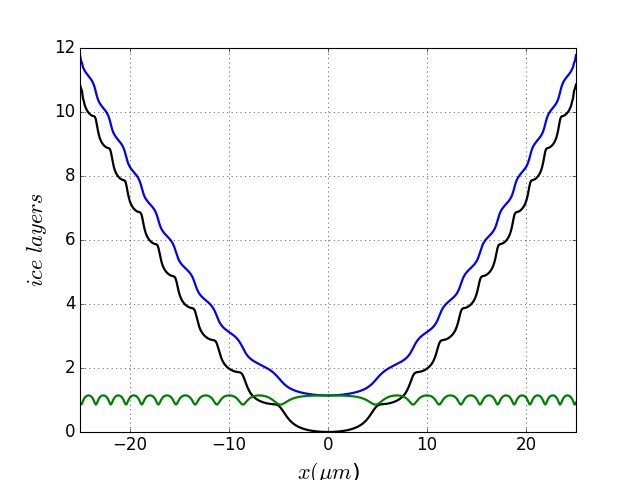

<IPython.core.display.Javascript object>


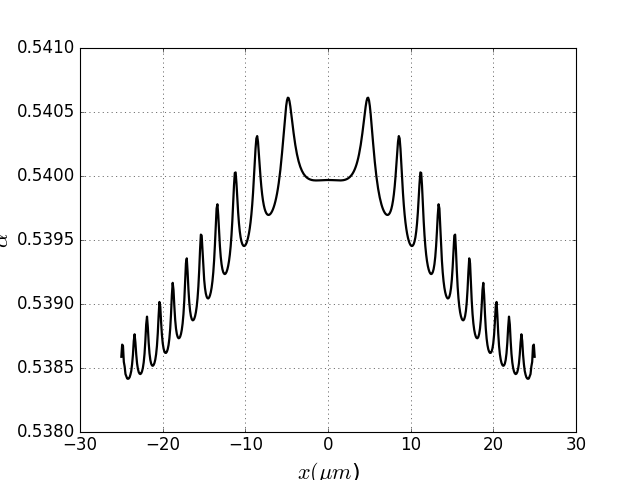

In [140]:
# Growth statistics
minpoint = min(Nice)
ncorner = 4
print"Height of Ice", minpoint
delta_Ntot_entire = Ntot-Ntotkeep[0]
print  "1-D growth, corner", delta_Ntot_entire[ncorner]
print  "1-D growth, center", delta_Ntot_entire[nmid]
growthrate_entire = delta_Ntot_entire/ttot*umpersec_over_mlyperus
print  "1-D Modeled growth rate, um/s", growthrate_entire[ncorner]
alpha = growthrate_entire/nu_kin/sigmastep
print  "1-D Modeled alpha, corner", alpha[ncorner]
print  "1-D Modeled alpha, center", alpha[nmid]
print  "Difference, %", (alpha[nmid]-alpha[ncorner])/alpha[ncorner]*100


# Comparisons with 0-D model
print  "0-D Modeled growth rate, um/s", growthrate_0d
print  "0-D Modeled alpha", alpha_0d
print  "Growth ratio 1D/0D", growthrate_entire[ncorner]/growthrate_0d

# Comparisons with Libbrecht
sigma0_L = 0.08
A_L = .28
alpha_L = A_L*np.exp(-sigma0_L/sigmastepmax)
print "Libbrecht's predicted growth rate, um/s", nu_kin*alpha_L*sigmastepmax
print "Libbrecht's predicted alpha", alpha_L

# Timing statistics
sec2 = time.time()
print "Time taken:", int((sec2-sec1)/60), "min", (sec2-sec1)%60, "secs"

# Plot
fignum +=1
plt.figure(fignum)
plt.plot(\
         x-xmid, Nice-minpoint, 'k', \
         x-xmid, Fliq+Nice-minpoint, 'b', \
         x-xmid, Fliq, 'g', lw=linewidth)
plt.xlabel(r'$x (\mu m$)',fontsize=fontsize)
plt.ylabel(r'$ice \ layers$',fontsize=fontsize)
plt.xlim([-xmid, xmid])
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.grid('on')


# Plot
fignum +=1
plt.figure(fignum)
plt.plot(x-xmid, alpha, 'k', lw=linewidth)
plt.xlabel(r'$x (\mu m$)',fontsize=fontsize)
plt.ylabel(r'$ \alpha $',fontsize=fontsize)
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.grid('on')



In [141]:
# Saving these results to file
print Nice[0]
if Nice[0] > 100000:
    Nice -= 100000
if Save_new_file:
    print "saving to", nextfile
    np.savez_compressed(nextfile, Nice=Nice, Fliq=Fliq, 
                        x=x, t=ttot,
                        Nbar=Nbar, Nstar=Nstar,
                        sigma0=sigma0, c_r=c_r, D=D, L=L, 
                        nu_kin=nu_kin, nu_kin_ml=nu_kin_ml, 
                        sigmastepmax=sigmastepmax, sigmastepstyle=sigmastepstyle)


7084.98579082
saving to NeshData/continuum_model6 20-5-2016[2][6].npz


In [142]:
if trajflag:
    print "saving to", trajfile
    np.savez_compressed(trajfile, Nice=Nicekeep, Fliq=Fliqkeep,
                        x=x, t=tkeep, 
                        Nbar=Nbar, Nstar=Nstar,
                        sigma0=sigma0, c_r=c_r, D=D, L=L, 
                        nu_kin=nu_kin, nu_kin_ml=nu_kin_ml, 
                        sigmastepmax=sigmastepmax, sigmastepstyle=sigmastepstyle)


saving to NeshData/continuum_model6 20-5-2016[2][6].traj.npz


In [143]:
if traj0flag:
    print "saving to", traj0file
    np.savez_compressed(traj0file, ykeep_0Darr=ykeep_0Darr,
                        x=x, tkeep_0D=tkeep_0D,  
                        sigma0=sigma0, c_r=c_r, D=D, L=L, 
                        nu_kin=nu_kin, nu_kin_ml=nu_kin_ml, 
                        sigmastepmax=sigmastepmax, sigmastepstyle=sigmastepstyle)

saving to NeshData/continuum_model6 20-5-2016[2][6].traj0.npz
